# 참고 문헌
https://www.kaggle.com/code/nugroho24/pre-trained-ptb-xl-mi-classification-with-lstm

(Binary Classification으로 만들어졌으나, 5개 Class에 대한 분류로 재구성)

# IMPORT DATA



The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 9.3 MB/s eta 0:00:00


In [ ]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

First of all I need to load metadata about patients and samples provided by dataset. All metadata will be loaded to **ECG_df** and **SCP_df** dataframes respectively.

In [ ]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

Dataset URL: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.72G/1.72G [01:33<00:00, 23.3MB/s]
100% 1.72G/1.72G [01:33<00:00, 19.8MB/s]


In [ ]:
import zipfile
import os

zip_file_path = '/content/ptb-xl-dataset.zip'
extract_path = '/kaggle/working/ptb-xl-dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
PATH_TO_DATA = '/kaggle/working/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [ ]:
ECG_df = ECG_df[(ECG_df['age'] >= 10) & (ECG_df['age'] < 40)].reset_index(drop=True)
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
1,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
2,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
3,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
4,19005,18.0,1,NaN,58.0,2,0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,20990,37.0,1,NaN,NaN,0,0,CS100 3,2001-01-20 15:49:14,sinusrhythmus lagetyp normal normales ekg 4.46...,...,False,NaN,", I-AVF,",NaN,NaN,NaN,NaN,2,records100/21000/21744_lr,records500/21000/21744_hr
2831,11171,28.0,0,NaN,NaN,0,0,CS100 3,2001-01-23 10:30:00,sinusrhythmus lagetyp normal normales ekg 4.46...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21758_lr,records500/21000/21758_hr
2832,16077,22.0,1,NaN,NaN,0,0,CS100 3,2001-01-27 11:43:56,sinus arrhythmie lagetyp normal unspezifisches...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21770_lr,records500/21000/21770_hr
2833,17583,35.0,1,NaN,NaN,0,0,CS100 3,2001-01-29 14:09:14,"sinusrhythmus linkstyp st & t abnorm, wahrsche...",...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,4,records100/21000/21787_lr,records500/21000/21787_hr


ECG samples are strattified to 10 groups. The authors of PTB-XL ECG dataset suggest use first 8 groups as the training samples. Last two groups then use as the validation and test sample set.
I will accept this suggestion on my following work.

In [ ]:
ECG_df.strat_fold.value_counts()

,count
strat_fold,
5,285
7,285
4,284
9,284
6,284
1,284
3,283
10,283
8,282


I am going to add one more column **scp_classes** to ECG_df dataset, which represents all superlasses (as a list of abbreviations) assigned to the sample by cardiologists.

In [ ]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)

ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

And finally I am going to load row data (ECG curves) to **ECG_data** dataset.

In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(2835, 1000, 12)

Now I have all data from **PTB-XL ECG dataset** loaded to Pandas dataframes or numpy arrays. So I can take a short look at them.

I do not want linger on data analysis for a long time. Very good job was already done by colleagues at [PTB XL Dataset Wrangling](https://www.kaggle.com/code/khyeh0719/ptb-xl-dataset-wrangling) notebook.

As an example I would like to show only one sample from ECG_data dataset:

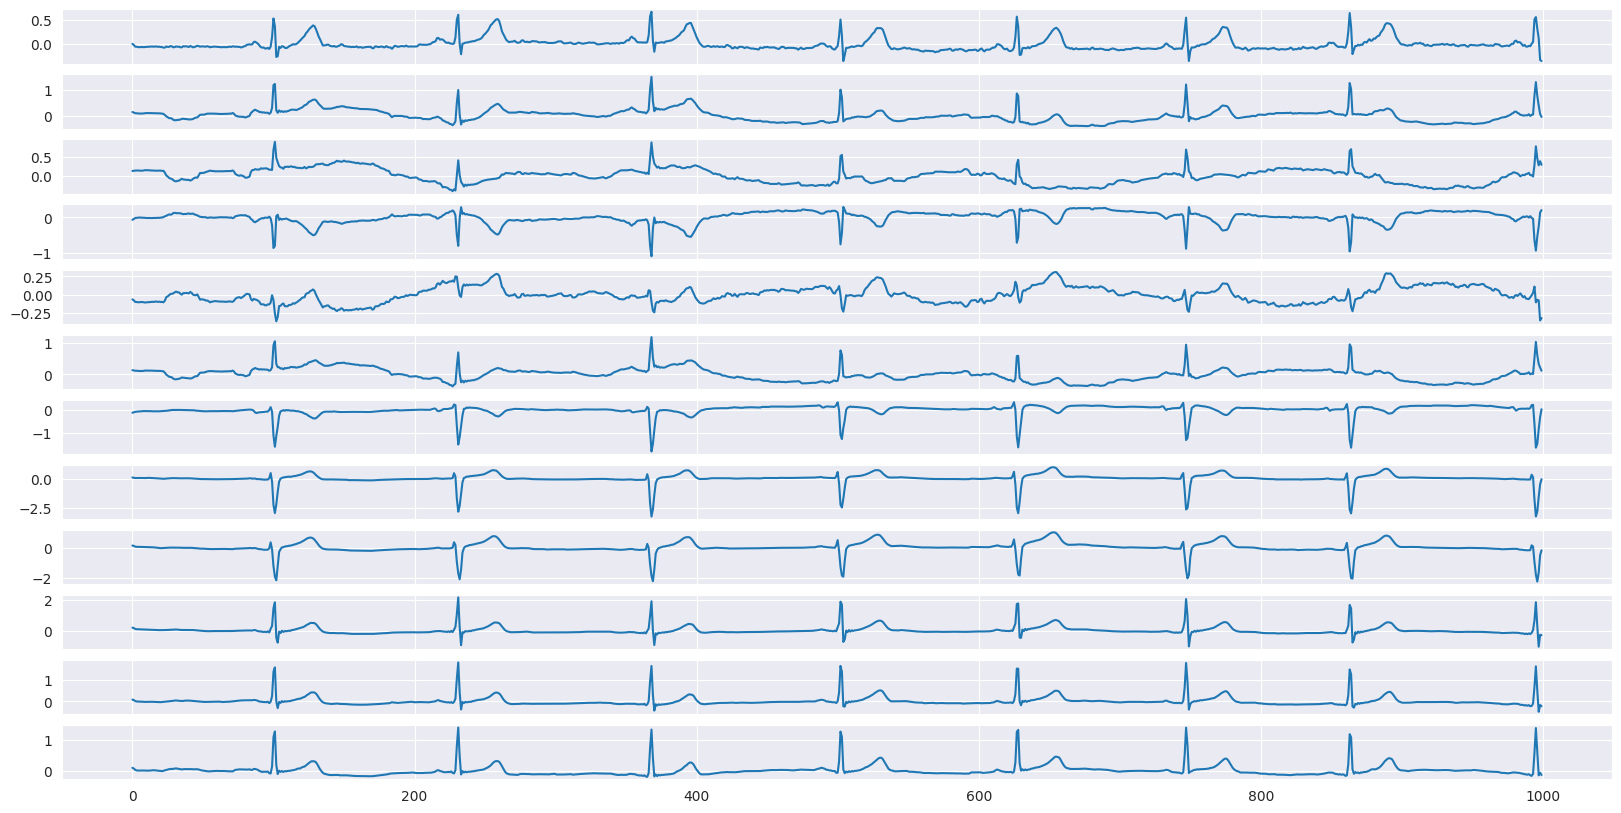

In [ ]:
sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

First problem, I would like to cope with, are null values in metadata dataframe. There is a quick look at the problem:

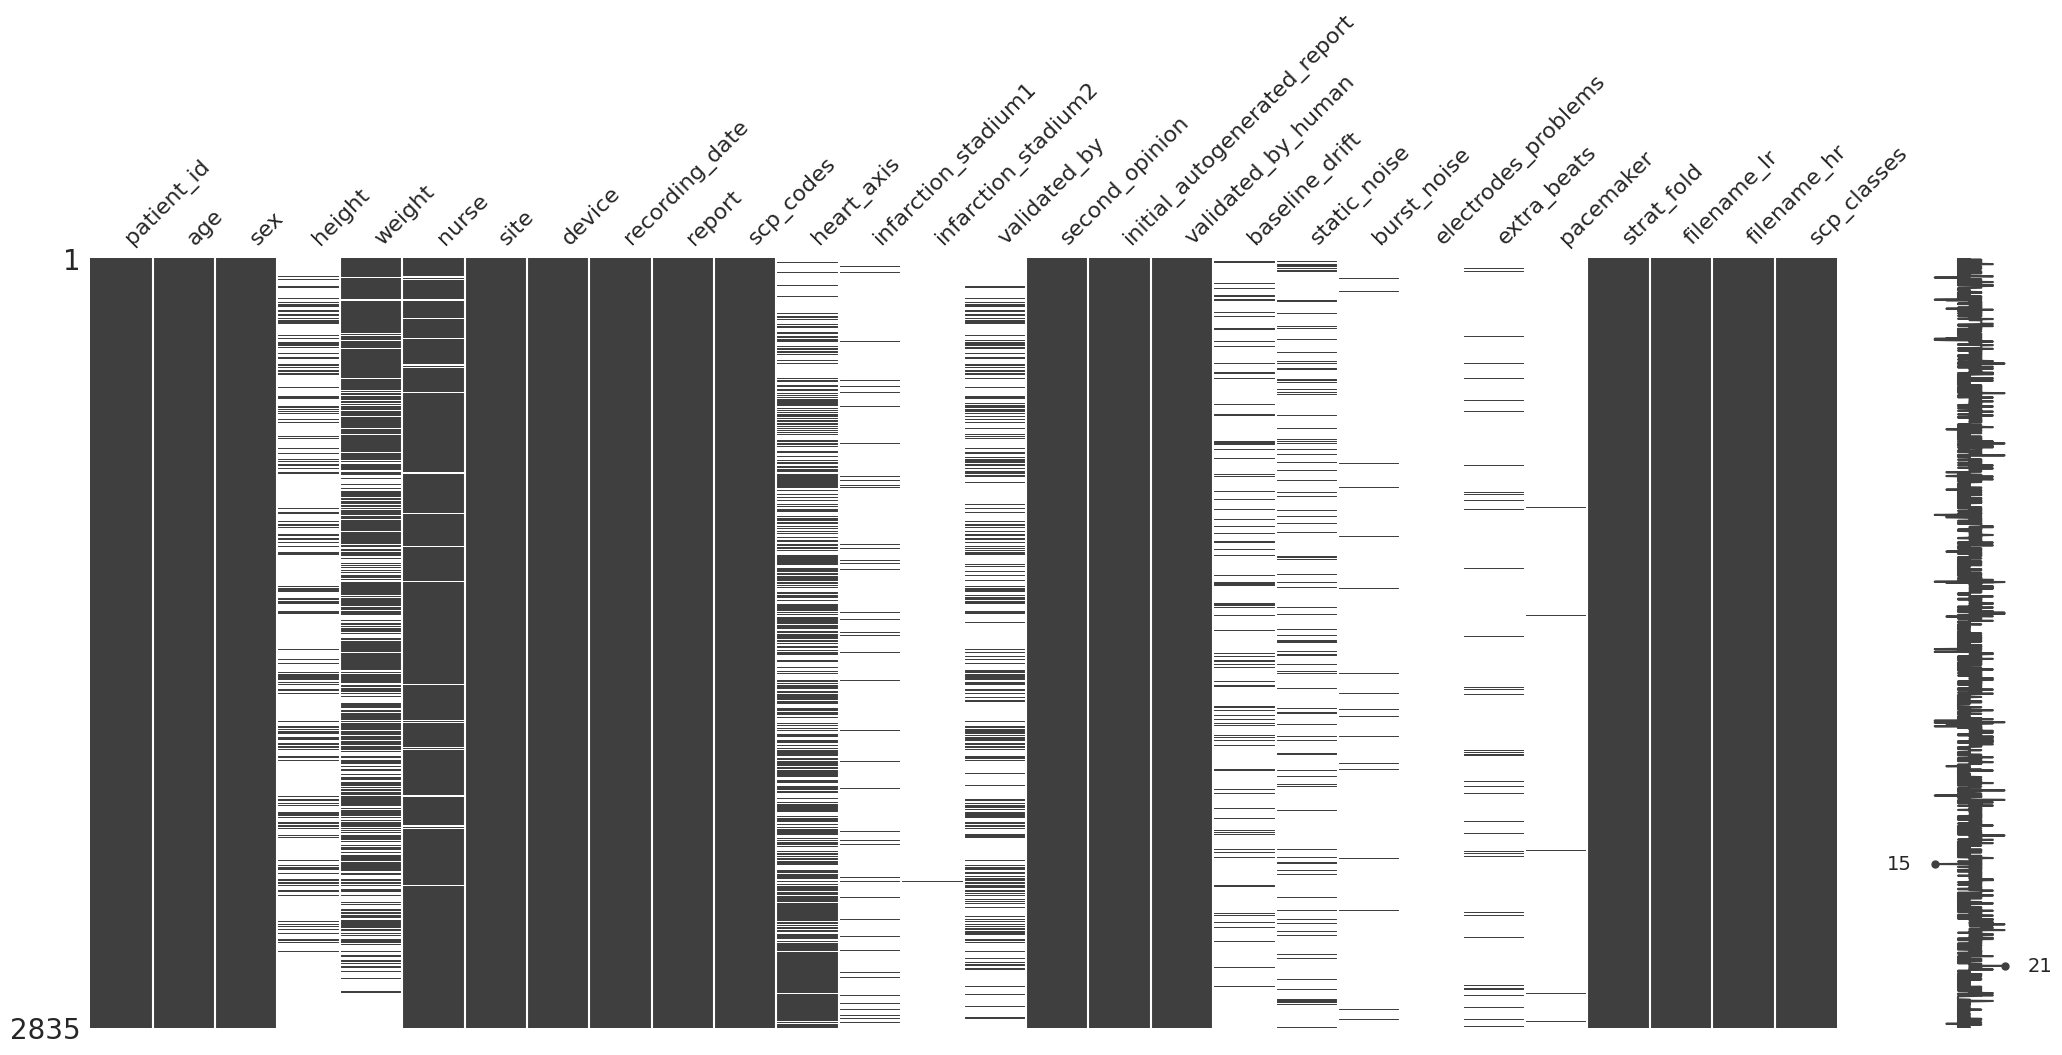

In [ ]:
import missingno as msno

msno.matrix(ECG_df)
plt.show()

And to add another angle of the view, there is an overview of unique values in all columns of metadata dataframe:

In [ ]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

,0
patient_id,2596
age,30
sex,2
height,52
weight,90
nurse,12
site,31
device,11
recording_date,2834
report,792


# Data preparation for modeling

I need first prepare input and output (targets) for my models.

As inputs I will use both patient metadata (now loaded in the ECG_df dataframe) and ECG curves (in the ECG_data numpy array) respectively. But both require some rework to be useful for modeling, which will be done in following few steps.

As outputs I will create new dataframe with rows equal to samples and columns corresponding with diagnosis superclasses.

Because I will have two inputs and one output, I will preffix all created dataframes as follows:
- X - prefix for patient and sample metadata
- Y - prefix for ECG curves
- Z - prefix for targets

## X dataframe ...

I won't use all columns from ECG_df dataframe, but only a subset of them.
Created dataframe **X** comprises only columns, witch are related to patient and his health condition. During dataframe creation I will cope with null values and mapping categorical columns to numerical representation.

In [ ]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

<ipython-input-15-494dc8d5c6e4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
<ipython-input-15-494dc8d5c6e4>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: 

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
0,19.0,0.0,0.0,70.0,0.0,0.0,0.0
1,37.0,1.0,0.0,69.0,0.0,0.0,0.0
2,24.0,0.0,0.0,82.0,0.0,0.0,0.0
3,19.0,1.0,0.0,70.0,0.0,0.0,0.0
4,18.0,1.0,0.0,58.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2830,37.0,1.0,0.0,0.0,0.0,0.0,0.0
2831,28.0,0.0,0.0,0.0,0.0,0.0,0.0
2832,22.0,1.0,0.0,0.0,0.0,0.0,0.0
2833,35.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe ...

At present I do not need to change data in the ECF_data dataframe, so I will use it as is.

## Z targets ...

I am going to create **Z** dataframe with columns corresponding to diagnoses superclasses.

In [ ]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2830,1,0,0,0,0
2831,1,0,0,0,0
2832,0,0,1,0,0
2833,0,0,1,0,0


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [ ]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(2268, 7) (2268, 1000, 12) (2268, 5)
(284, 7) (284, 1000, 12) (284, 5)
(283, 7) (283, 1000, 12) (283, 5)


In [ ]:
"""
# Step 1: Apply the filter to training data
mask_train = (Z_train['NORM'] == 1) | (Z_train['MI'] == 1)
X_train_filtered = X_train[mask_train]
Y_train_filtered = Y_train[mask_train]
Z_train_filtered = Z_train[mask_train].drop(columns=['STTC', 'CD', 'HYP'])

# Step 2: Apply the filter to validation data
mask_valid = (Z_valid['NORM'] == 1) | (Z_valid['MI'] == 1)
X_valid_filtered = X_valid[mask_valid]
Y_valid_filtered = Y_valid[mask_valid]
Z_valid_filtered = Z_valid[mask_valid].drop(columns=['STTC', 'CD', 'HYP'])

# Step 3: Apply the filter to test data
mask_test = (Z_test['NORM'] == 1) | (Z_test['MI'] == 1)
X_test_filtered = X_test[mask_test]
Y_test_filtered = Y_test[mask_test]
Z_test_filtered = Z_test[mask_test].drop(columns=['STTC', 'CD', 'HYP'])

# Check the shapes after filtering
print("Train shapes:", X_train_filtered.shape, Y_train_filtered.shape, Z_train_filtered.shape)
print("Validation shapes:", X_valid_filtered.shape, Y_valid_filtered.shape, Z_valid_filtered.shape)
print("Test shapes:", X_test_filtered.shape, Y_test_filtered.shape, Z_test_filtered.shape)
"""

'\n# Step 1: Apply the filter to training data\nmask_train = (Z_train[\'NORM\'] == 1) | (Z_train[\'MI\'] == 1)\nX_train_filtered = X_train[mask_train]\nY_train_filtered = Y_train[mask_train]\nZ_train_filtered = Z_train[mask_train].drop(columns=[\'STTC\', \'CD\', \'HYP\'])\n\n# Step 2: Apply the filter to validation data\nmask_valid = (Z_valid[\'NORM\'] == 1) | (Z_valid[\'MI\'] == 1)\nX_valid_filtered = X_valid[mask_valid]\nY_valid_filtered = Y_valid[mask_valid]\nZ_valid_filtered = Z_valid[mask_valid].drop(columns=[\'STTC\', \'CD\', \'HYP\'])\n\n# Step 3: Apply the filter to test data\nmask_test = (Z_test[\'NORM\'] == 1) | (Z_test[\'MI\'] == 1)\nX_test_filtered = X_test[mask_test]\nY_test_filtered = Y_test[mask_test]\nZ_test_filtered = Z_test[mask_test].drop(columns=[\'STTC\', \'CD\', \'HYP\'])\n\n# Check the shapes after filtering\nprint("Train shapes:", X_train_filtered.shape, Y_train_filtered.shape, Z_train_filtered.shape)\nprint("Validation shapes:", X_valid_filtered.shape, Y_valid_

In [ ]:
"""
X_train_filtered.columns
"""

'\nX_train_filtered.columns\n'

In [ ]:
"""
Z_train_filtered.columns
"""

'\nZ_train_filtered.columns\n'

## Standardization of all input datasets

Wise people sometimes recommend to normalize/standardize data before using them for modeling and predictions. I will obey their opinions.

In [ ]:
"""
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the filtered X_train data
X_scaler.fit(X_train_filtered)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_filtered_scaled = pd.DataFrame(X_scaler.transform(X_train_filtered), columns=X_train_filtered.columns)
X_valid_filtered_scaled = pd.DataFrame(X_scaler.transform(X_valid_filtered), columns=X_valid_filtered.columns)
X_test_filtered_scaled  = pd.DataFrame(X_scaler.transform(X_test_filtered), columns=X_test_filtered.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_filtered_scaled.shape)
print("Scaled Validation shape:", X_valid_filtered_scaled.shape)
print("Scaled Test shape:", X_test_filtered_scaled.shape)
"""

'\nfrom sklearn.preprocessing import StandardScaler\n\n# Step 1: Initialize the scaler\nX_scaler = StandardScaler()\n\n# Step 2: Fit the scaler only on the filtered X_train data\nX_scaler.fit(X_train_filtered)\n\n# Step 3: Transform the training, validation, and test sets using the fitted scaler\nX_train_filtered_scaled = pd.DataFrame(X_scaler.transform(X_train_filtered), columns=X_train_filtered.columns)\nX_valid_filtered_scaled = pd.DataFrame(X_scaler.transform(X_valid_filtered), columns=X_valid_filtered.columns)\nX_test_filtered_scaled  = pd.DataFrame(X_scaler.transform(X_test_filtered), columns=X_test_filtered.columns)\n\n# Check the shapes to ensure everything is scaled correctly\nprint("Scaled Train shape:", X_train_filtered_scaled.shape)\nprint("Scaled Validation shape:", X_valid_filtered_scaled.shape)\nprint("Scaled Test shape:", X_test_filtered_scaled.shape)\n'

In [ ]:
"""
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the filtered Y_train data
Y_scaler.fit(Y_train_filtered.reshape(-1, Y_train_filtered.shape[-1]))

# Step 2: Transform the filtered training, validation, and test sets
Y_train_filtered_scaled = Y_scaler.transform(Y_train_filtered.reshape(-1, Y_train_filtered.shape[-1])).reshape(Y_train_filtered.shape)
Y_valid_filtered_scaled = Y_scaler.transform(Y_valid_filtered.reshape(-1, Y_valid_filtered.shape[-1])).reshape(Y_valid_filtered.shape)
Y_test_filtered_scaled  = Y_scaler.transform(Y_test_filtered.reshape(-1, Y_test_filtered.shape[-1])).reshape(Y_test_filtered.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_filtered_scaled.shape)
print("Scaled Validation Y shape:", Y_valid_filtered_scaled.shape)
print("Scaled Test Y shape:", Y_test_filtered_scaled.shape)
"""

'\nfrom sklearn.preprocessing import StandardScaler\n\n# Initialize the scaler for Y data\nY_scaler = StandardScaler()\n\n# Step 1: Fit the scaler only on the filtered Y_train data\nY_scaler.fit(Y_train_filtered.reshape(-1, Y_train_filtered.shape[-1]))\n\n# Step 2: Transform the filtered training, validation, and test sets\nY_train_filtered_scaled = Y_scaler.transform(Y_train_filtered.reshape(-1, Y_train_filtered.shape[-1])).reshape(Y_train_filtered.shape)\nY_valid_filtered_scaled = Y_scaler.transform(Y_valid_filtered.reshape(-1, Y_valid_filtered.shape[-1])).reshape(Y_valid_filtered.shape)\nY_test_filtered_scaled  = Y_scaler.transform(Y_test_filtered.reshape(-1, Y_test_filtered.shape[-1])).reshape(Y_test_filtered.shape)\n\n# Check the shapes to ensure everything is scaled correctly\nprint("Scaled Train Y shape:", Y_train_filtered_scaled.shape)\nprint("Scaled Validation Y shape:", Y_valid_filtered_scaled.shape)\nprint("Scaled Test Y shape:", Y_test_filtered_scaled.shape)\n'

# LSTM


In [ ]:
"""
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM
X_train = Y_train_filtered_scaled  # Using the signal data as X
X_valid = Y_valid_filtered_scaled
X_test  = Y_test_filtered_scaled

# Z is the target (NORM, MI)
y_train = Z_train_filtered[['NORM', 'MI']].values
y_valid = Z_valid_filtered[['NORM', 'MI']].values
y_test  = Z_test_filtered[['NORM', 'MI']].values

# Step 2: Define the LSTM model
model_lstm = Sequential()

# LSTM layer with 50 units
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout to prevent overfitting
model_lstm.add(Dropout(0.2))

# Fully connected layer with softmax for binary classification
model_lstm.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Define callbacks

# 1. Save the best model during training
checkpoint = ModelCheckpoint(filepath='best_lstm_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

# 2. Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

# 3. Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1)

# Step 4: Train the model with callbacks
history = model_lstm.fit(X_train, y_train,
                         epochs=50,
                         batch_size=20,
                         validation_data=(X_valid, y_valid),
                         callbacks=[checkpoint, early_stopping, reduce_lr],
                         verbose=1)

# Step 5: Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 6: Evaluate on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 7: Save the final model and training history
model_lstm.save('final_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_lstm.csv', index=False)

# Step 8: Confusion Matrix
# Predict on the test set
y_pred = model_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 9: Save confusion matrix to file
# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
cm_df.to_csv('confusion_matrix_lstm.csv')

# Save confusion matrix as PNG
plt.savefig('confusion_matrix_lstm.png')
"""

'\nimport numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nimport matplotlib.pyplot as plt\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\nfrom sklearn.metrics import confusion_matrix\nimport seaborn as sns\n\n# Step 1: Prepare data\n# Ensure the input is 3D (samples, timesteps, features) for LSTM\nX_train = Y_train_filtered_scaled  # Using the signal data as X\nX_valid = Y_valid_filtered_scaled\nX_test  = Y_test_filtered_scaled\n\n# Z is the target (NORM, MI)\ny_train = Z_train_filtered[[\'NORM\', \'MI\']].values\ny_valid = Z_valid_filtered[[\'NORM\', \'MI\']].values\ny_test  = Z_test_filtered[[\'NORM\', \'MI\']].values\n\n# Step 2: Define the LSTM model\nmodel_lstm = Sequential()\

### 가보자

In [ ]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(2268, 7) (2268, 1000, 12) (2268, 5)
(284, 7) (284, 1000, 12) (284, 5)
(283, 7) (283, 1000, 12) (283, 5)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the filtered X_train data
X_scaler.fit(X_train)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test_scaled  = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Validation shape:", X_valid_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)

Scaled Train shape: (2268, 7)
Scaled Validation shape: (284, 7)
Scaled Test shape: (283, 7)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the filtered Y_train data
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

# Step 2: Transform the filtered training, validation, and test sets
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_valid_scaled = Y_scaler.transform(Y_valid.reshape(-1, Y_valid.shape[-1])).reshape(Y_valid.shape)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_scaled.shape)
print("Scaled Validation Y shape:", Y_valid_scaled.shape)
print("Scaled Test Y shape:", Y_test_scaled.shape)

Scaled Train Y shape: (2268, 1000, 12)
Scaled Validation Y shape: (284, 1000, 12)
Scaled Test Y shape: (283, 1000, 12)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2219 - loss: 1.5956
Epoch 1: val_accuracy improved from -inf to 0.64789, saving model to best_lstm_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.2230 - loss: 1.5952 - val_accuracy: 0.6479 - val_loss: 1.4443 - learning_rate: 1.0000e-04
Epoch 2/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6592 - loss: 1.3922
Epoch 2: val_accuracy improved from 0.64789 to 0.80634, saving model to best_lstm_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6602 - loss: 1.3904 - val_accuracy: 0.8063 - val_loss: 0.9825 - learning_rate: 1.0000e-04
Epoch 3/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8118 - loss: 0.8723
Epoch 3: val_accuracy improved from 0.80634 to 0.80986, saving model to best_lstm_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8117 - loss: 0.8717 - val_accuracy: 0.8099 - val_loss: 0.7563 - learning_rate: 1.0000e-04
Epoch 4/50
113/114 ━━━

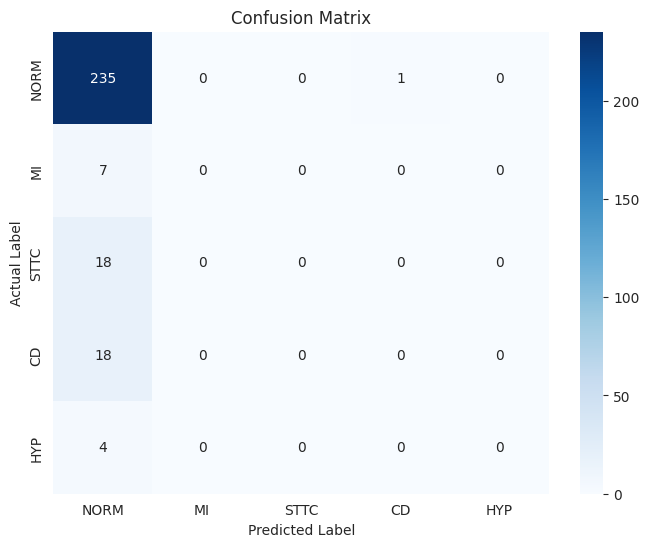

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM
X_train = Y_train_scaled  # Using the signal data as X
X_valid = Y_valid_scaled
X_test  = Y_test_scaled

# Z는 타겟 (NORM, MI, STTC, CD, HYP)
y_train = Z_train[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_valid = Z_valid[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_test  = Z_test[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values

# Step 2: One-hot encoding
y_train = tf.keras.utils.to_categorical(np.argmax(y_train, axis=1), num_classes=5)
y_valid = tf.keras.utils.to_categorical(np.argmax(y_valid, axis=1), num_classes=5)
y_test  = tf.keras.utils.to_categorical(np.argmax(y_test, axis=1), num_classes=5)

# Step 3: Define the LSTM model
model_lstm = Sequential()

# LSTM layer with 50 units
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout to prevent overfitting
model_lstm.add(Dropout(0.2))

# Fully connected layer with softmax for multi-class classification
model_lstm.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Define callbacks
checkpoint = ModelCheckpoint(filepath='best_lstm_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1)

# Step 5: Train the model with callbacks
history = model_lstm.fit(X_train, y_train,
                         epochs=50,
                         batch_size=20,
                         validation_data=(X_valid, y_valid),
                         callbacks=[checkpoint, early_stopping, reduce_lr],
                         verbose=1)

# Step 6: Evaluate on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 7: Confusion Matrix
y_pred = model_lstm.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'], yticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 8: Save confusion matrix to file
cm_df = pd.DataFrame(cm, index=['NORM', 'MI', 'STTC', 'CD', 'HYP'], columns=['Predicted NORM', 'Predicted MI', 'Predicted STTC', 'Predicted CD', 'Predicted HYP'])
cm_df.to_csv('confusion_matrix_lstm.csv')


<function matplotlib.pyplot.show(close=None, block=None)>

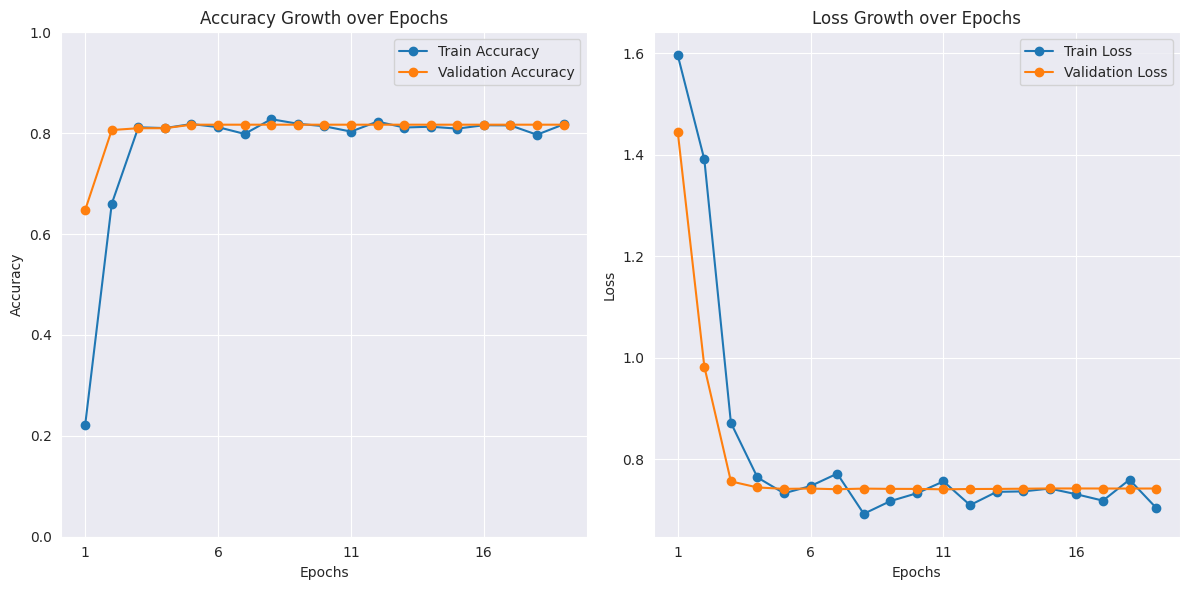

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 21)

# 정확도
train_accuracy = [0.2219, 0.6602, 0.8117, 0.8102, 0.8182, 0.8120, 0.7986, 0.8278, 0.8188, 0.8138,
                  0.8032, 0.8231, 0.8113, 0.8129, 0.8091, 0.8158, 0.8155, 0.7970, 0.8175, None]

# 검증 정확도
val_accuracy = [0.6479, 0.8063, 0.8099, 0.8099, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169,
                0.8169, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169, 0.8169, None]

# 손실
train_loss = [1.5956, 1.3904, 0.8717, 0.7640, 0.7329, 0.7472, 0.7716, 0.6925, 0.7175, 0.7330,
              0.7563, 0.7096, 0.7357, 0.7366, 0.7422, 0.7310, 0.7184, 0.7597, 0.7044, None]

# 검증 손실
val_loss = [1.4443, 0.9825, 0.7563, 0.7444, 0.7416, 0.7422, 0.7409, 0.7421, 0.7416, 0.7415,
            0.7407, 0.7413, 0.7415, 0.7419, 0.7424, 0.7424, 0.7423, 0.7422, 0.7423, None]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 21, 5))
plt.ylim(0, 1)
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, 21, 5))
plt.legend()

plt.tight_layout()
plt.show


# STACKED LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3642 - loss: 1.5561
Epoch 1: val_accuracy improved from -inf to 0.78873, saving model to best_stacked_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.3665 - loss: 1.5551 - val_accuracy: 0.7887 - val_loss: 1.2691 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7749 - loss: 1.1806
Epoch 2: val_accuracy improved from 0.78873 to 0.81690, saving model to best_stacked_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7750 - loss: 1.1787 - val_accuracy: 0.8169 - val_loss: 0.7608 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7871 - loss: 0.8556
Epoch 3: val_accuracy did not improve from 0.81690
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7874 - loss: 0.8546 - val_accuracy: 0.8169 - val_loss: 0.7382 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy

Test Loss: 0.6721453666687012, Test Accuracy: 0.833922266960144
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


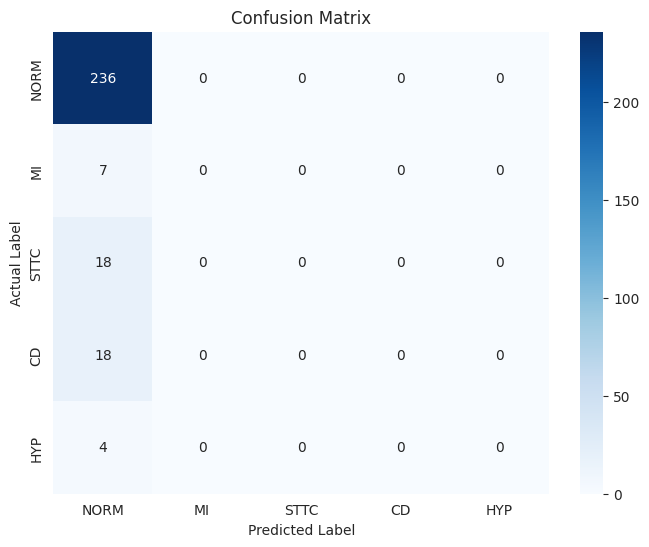

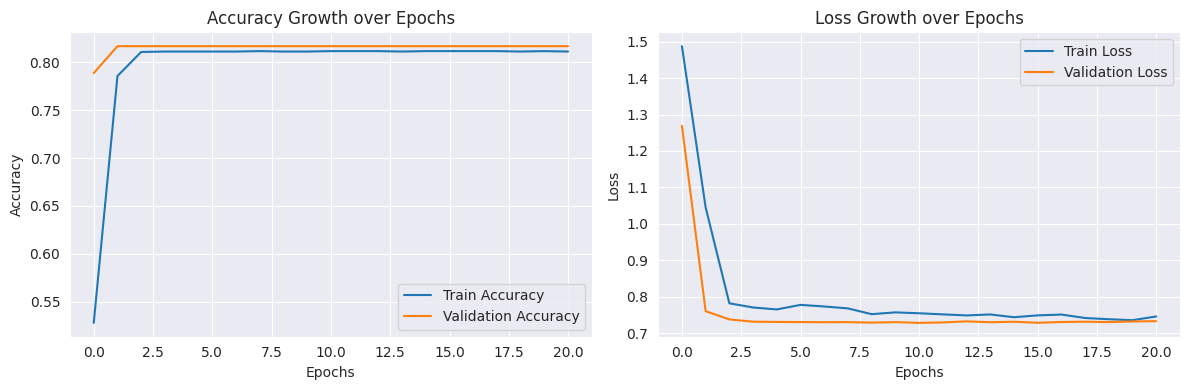

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM
X_train = Y_train_scaled  # Using the signal data as X
X_valid = Y_valid_scaled
X_test  = Y_test_scaled

# Z는 타겟 (NORM, MI, STTC, CD, HYP)
y_train = Z_train[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_valid = Z_valid[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_test  = Z_test[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values

# Step 2: One-hot encoding
y_train = tf.keras.utils.to_categorical(np.argmax(y_train, axis=1), num_classes=5)
y_valid = tf.keras.utils.to_categorical(np.argmax(y_valid, axis=1), num_classes=5)
y_test  = tf.keras.utils.to_categorical(np.argmax(y_test, axis=1), num_classes=5)

# Step 3: Define the stacked LSTM model
stacked_lstm_model = Sequential()

# Stacked LSTM layers
stacked_lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
stacked_lstm_model.add(Dropout(0.3))
stacked_lstm_model.add(LSTM(50, return_sequences=False))
stacked_lstm_model.add(Dropout(0.3))

# Dense layers
stacked_lstm_model.add(Dense(64, activation='relu'))
stacked_lstm_model.add(Dropout(0.2))
stacked_lstm_model.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
optimizer = Adam(learning_rate=0.0001)
stacked_lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Define callbacks
checkpoint = ModelCheckpoint(filepath='best_stacked_lstm_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1)

# Step 5: Train the stacked LSTM model with callbacks
history3 = stacked_lstm_model.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[checkpoint, early_stopping, reduce_lr],
                                  verbose=1)

# Step 6: Evaluate on the test set
test_loss3, test_accuracy3 = stacked_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss3}, Test Accuracy: {test_accuracy3}")

# Step 7: Save the final model and training history
stacked_lstm_model.save('final_stacked_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history3.history)
history_df.to_csv('training_history_stacked_lstm.csv', index=False)

# Step 8: Confusion Matrix
# Predict on the test set
y_pred = stacked_lstm_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'], yticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 9: Save confusion matrix to file
cm_df = pd.DataFrame(cm, index=['NORM', 'MI', 'STTC', 'CD', 'HYP'], columns=['Predicted NORM', 'Predicted MI', 'Predicted STTC', 'Predicted CD', 'Predicted HYP'])
cm_df.to_csv('confusion_matrix_stacked_lstm.csv')

# Step 10: Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# BI LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3806 - loss: 1.5484
Epoch 1: val_accuracy improved from -inf to 0.80282, saving model to best_bi_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.3831 - loss: 1.5469 - val_accuracy: 0.8028 - val_loss: 1.1250 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7889 - loss: 1.0283
Epoch 2: val_accuracy improved from 0.80282 to 0.81690, saving model to best_bi_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7891 - loss: 1.0265 - val_accuracy: 0.8169 - val_loss: 0.7566 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8158 - loss: 0.7845
Epoch 3: val_accuracy did not improve from 0.81690
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.8157 - loss: 0.7846 - val_accuracy: 0.8169 - val_loss: 0.7373 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy

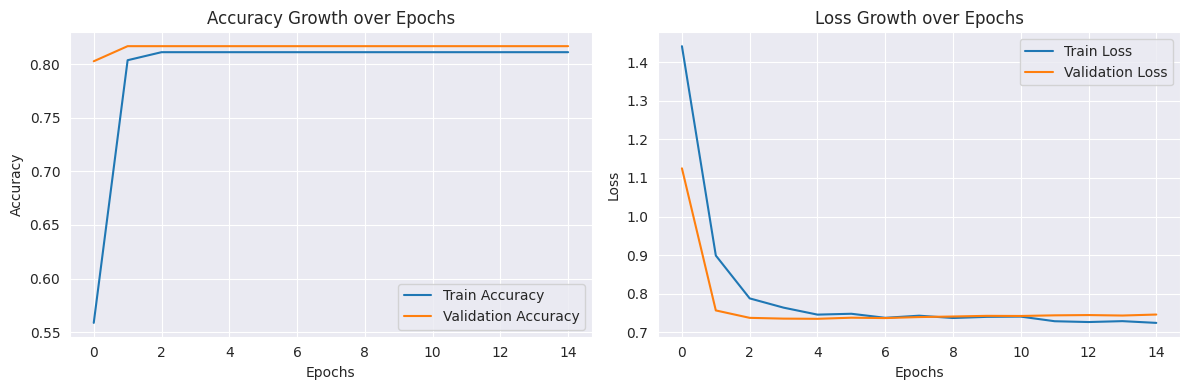

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8119 - loss: 0.7584


Test Loss: 0.6769891381263733, Test Accuracy: 0.833922266960144
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


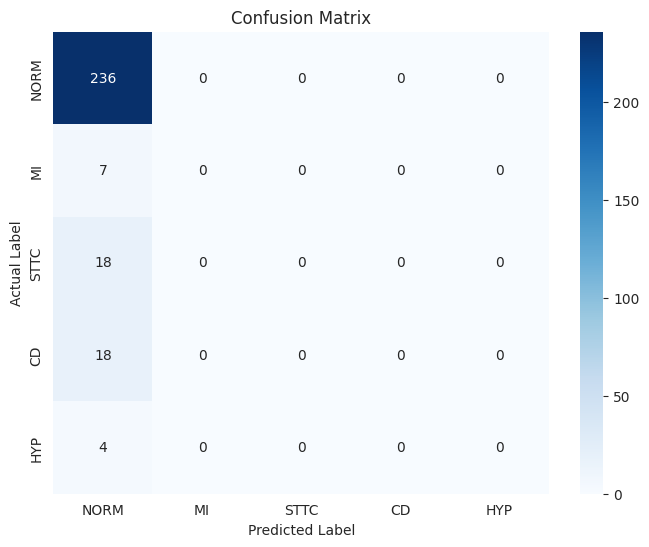

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM
X_train = Y_train_scaled  # Using the signal data as X
X_valid = Y_valid_scaled
X_test  = Y_test_scaled

# Z는 타겟 (NORM, MI, STTC, CD, HYP)
y_train = Z_train[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_valid = Z_valid[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
y_test  = Z_test[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values

# Step 2: One-hot encoding
y_train = tf.keras.utils.to_categorical(np.argmax(y_train, axis=1), num_classes=5)
y_valid = tf.keras.utils.to_categorical(np.argmax(y_valid, axis=1), num_classes=5)
y_test  = tf.keras.utils.to_categorical(np.argmax(y_test, axis=1), num_classes=5)

# Step 3: Define the Bidirectional LSTM model
bi_lstm_model = Sequential()

# Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
bi_lstm_model.add(Dropout(0.3))
bi_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))
bi_lstm_model.add(Dropout(0.3))

# Dense layers
bi_lstm_model.add(Dense(64, activation='relu'))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
optimizer = Adam(learning_rate=0.0001)
bi_lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Define callbacks
checkpoint = ModelCheckpoint(filepath='best_bi_lstm_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1)

# Step 5: Train the Bidirectional LSTM model with callbacks
history2 = bi_lstm_model.fit(X_train, y_train,
                             epochs=50,
                             batch_size=32,
                             validation_data=(X_valid, y_valid),
                             callbacks=[checkpoint, early_stopping, reduce_lr],
                             verbose=1)

# Step 6: Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 7: Evaluate on the test set
test_loss, test_accuracy = bi_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 8: Save the final model and training history
bi_lstm_model.save('final_bi_lstm_model.h5')  # Save the final model

# Save history to CSV
history_df = pd.DataFrame(history2.history)
history_df.to_csv('training_history_bi_lstm.csv', index=False)

# Step 9: Confusion Matrix
# Predict on the test set
y_pred = bi_lstm_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'], yticklabels=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 10: Save confusion matrix to file
cm_df = pd.DataFrame(cm, index=['NORM', 'MI', 'STTC', 'CD', 'HYP'], columns=['Predicted NORM', 'Predicted MI', 'Predicted STTC', 'Predicted CD', 'Predicted HYP'])
cm_df.to_csv('confusion_matrix_bi_lstm.csv')
